In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import transforms
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt
import pathlib
import pytorch_lightning as pl
import PIL.Image as Image

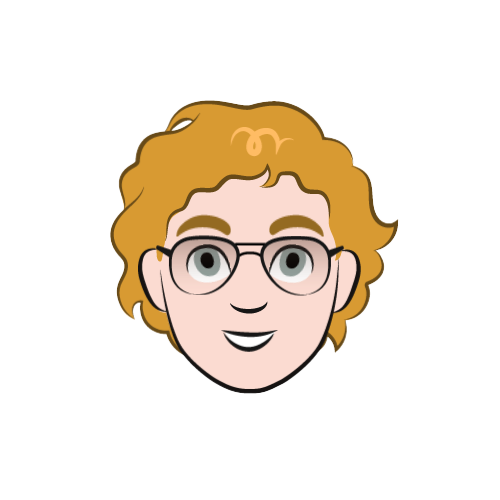

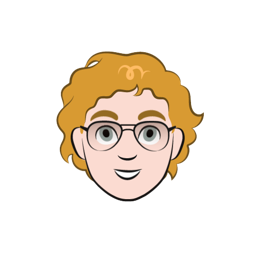

In [2]:
img = Image.open("./data/faces/cartoonset10k/cs1048486361028912.png")
display(img)
display(img.resize((256, 256)))

In [3]:
class UnlabeledImageDataset(Dataset):
    def __init__(self, folder_path, transform=None, dataset_size=None):
        self.folder_path = folder_path
        self.transform = transform
        self.image_paths = list(pathlib.Path("./data/faces/cartoonset10k/").glob("*.png"))
        if dataset_size:
            self.image_paths = self.image_paths[:dataset_size]
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = UnlabeledImageDataset("./data/faces/cartoonset10k", transform=transform)

In [5]:
batch = torch.stack([dataset[i] for i in range(10)])
batch.shape

torch.Size([10, 3, 256, 256])

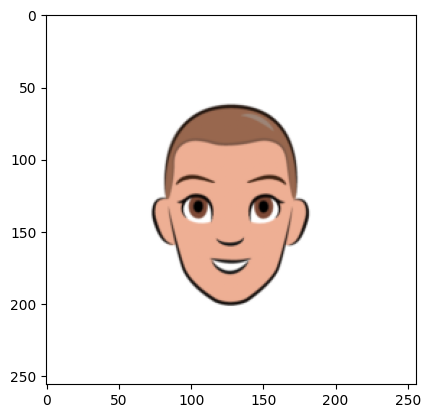

In [6]:
plt.imshow(batch[0].permute(1, 2, 0))

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3,padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1,bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 1, kernel_size=3,padding=1, bias=False),
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128, bias=False),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        cnn_output = self.cnn_layers(input)
        output = self.fc_layers(cnn_output)
        return output
        # return output.view(-1, 1).squeeze(0)

In [8]:
discriminator = Discriminator()
discriminator

Discriminator(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1,

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_dim = 100) -> None:
        super().__init__()
        self.latent_dim = latent_dim
        self.fc_layers = nn.Sequential(
            nn.Linear(latent_dim, 256*4*4),
            nn.LeakyReLU(0.2)
        )
        
        self.cnn_layers = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.Tanh()
            nn.Sigmoid()
        )

    def forward(self, X):
        X = self.fc_layers(X)
        X = X.view(-1, 256, 4, 4)
        X = self.cnn_layers(X)
        return X


In [10]:
generator = Generator()

batch = torch.randn(10, 100)

generator(batch).shape

torch.Size([10, 3, 256, 256])

In [11]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim, lr=0.0002, discriminator_update_threshold=0.0001):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization = False

        self.generator = Generator(latent_dim=latent_dim)
        self.discriminator = Discriminator()

        self.validation_step_outputs = []

        self.vaidation_z = torch.randn(6, latent_dim)

    def forward(self, x):
        return self.generator(x)
    
    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)
    
    def training_step(self, batch):
        imgs = batch

        optimizer_g, optimizer_d = self.optimizers()

        # sample noise
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim)
        z = z.type_as(imgs)

        # train generator
        # generate images
        self.toggle_optimizer(optimizer_g)
        self.generated_imgs = self(z)

        # log sampled images
        sample_imgs = self.generated_imgs[:6]
        grid = torchvision.utils.make_grid(sample_imgs)
        self.logger.experiment.add_image("train/generated_images", grid, self.current_epoch)

        # ground truth result (ie: all fake)
        # put on GPU because we created this tensor inside training_loop
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        # adversarial loss is binary cross-entropy
        g_loss = self.adversarial_loss(self.discriminator(self.generated_imgs), valid)
        self.log("g_loss", g_loss, prog_bar=True)
        self.manual_backward(g_loss)
        optimizer_g.step()
        optimizer_g.zero_grad()
        self.untoggle_optimizer(optimizer_g)

        # train discriminator
        # Measure discriminator's ability to classify real from generated samples
        self.toggle_optimizer(optimizer_d)

        # how well can it label as real?
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        real_loss = self.adversarial_loss(self.discriminator(imgs), valid)

        # how well can it label as fake?
        fake = torch.zeros(imgs.size(0), 1)
        fake = fake.type_as(imgs)

        fake_loss = self.adversarial_loss(self.discriminator(self.generated_imgs.detach()), fake)

        # discriminator loss is the average of these
        d_loss = (real_loss + fake_loss) / 2
        self.log("d_loss", d_loss, prog_bar=True)
        self.manual_backward(d_loss)
        if d_loss.item() > self.hparams.discriminator_update_threshold:
            optimizer_d.step()
        optimizer_d.zero_grad()
        self.untoggle_optimizer(optimizer_d)

    def validation_step(self, batch, batch_idx):
        pass
    
    def on_train_epoch_end(self):
        self.plot_images()
    
    def plot_images(self):
        z = self.vaidation_z.to(self.device)
        print("epoch: ", self.current_epoch)

        sample_imgs = self.generator(z).cpu()

        fig = plt.figure()

        for i in range(sample_imgs.size(0)):
            ax = fig.add_subplot(2, 3, i+1)
            ax.imshow(sample_imgs[i].detach().permute(1, 2, 0))
            ax.axis("off")

        plt.show()



    def configure_optimizers(self):
        lr = self.hparams.lr
        generator_optimizer = torch.optim.Adam(self.generator.parameters(), lr=lr)
        discriminator_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=lr)

        return [generator_optimizer, discriminator_optimizer], []


In [12]:
gan = GAN(latent_dim=100)

epoch:  0


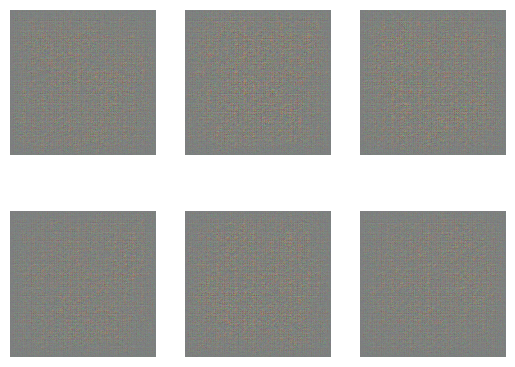

In [13]:
gan.plot_images()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/kamil/miniconda3/envs/python/lib/python3.12/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 1.1 M  | train
1 | discriminator | Discriminator | 424 K  | train
--------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.148     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

epoch:  0


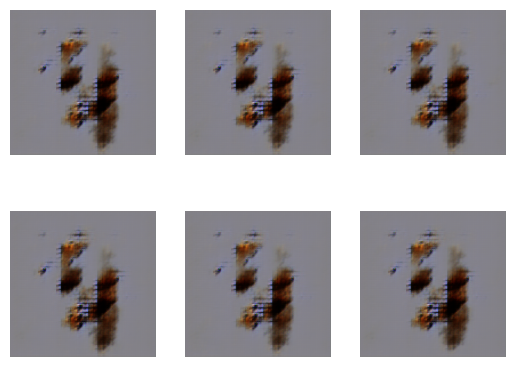

epoch:  1


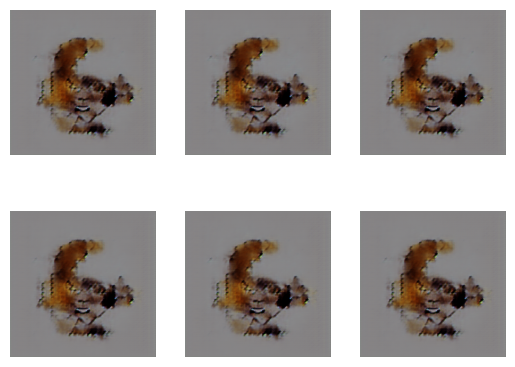

epoch:  2


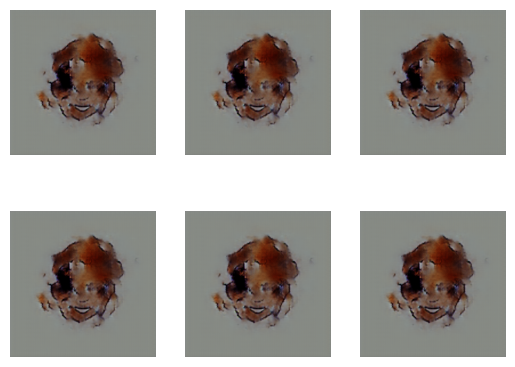

epoch:  3


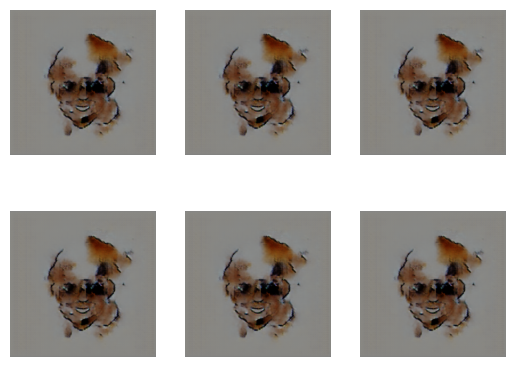

epoch:  4


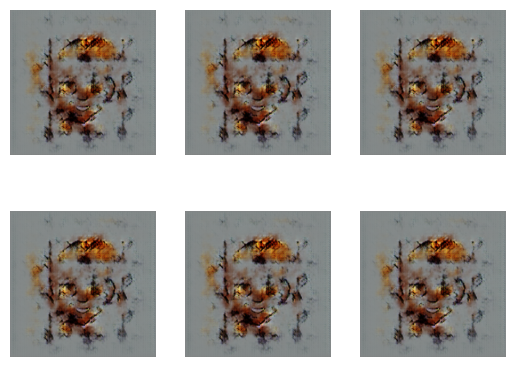

epoch:  5


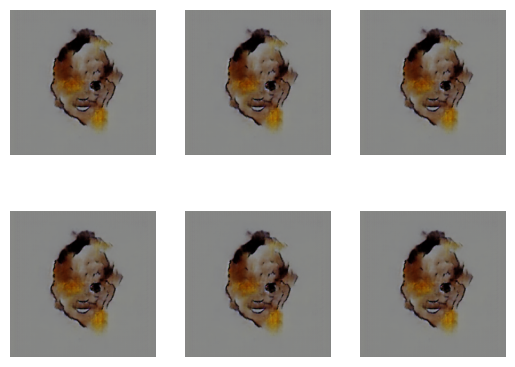

epoch:  6


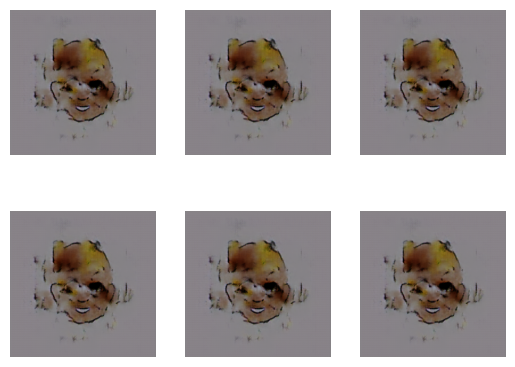

epoch:  7


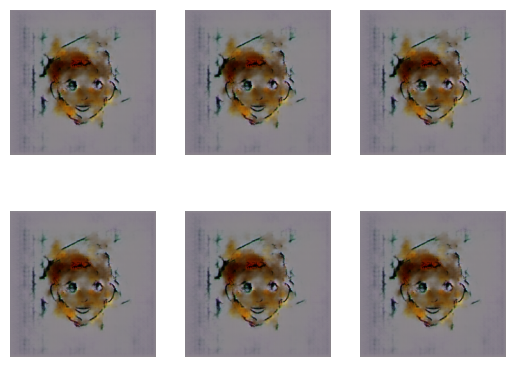

epoch:  8


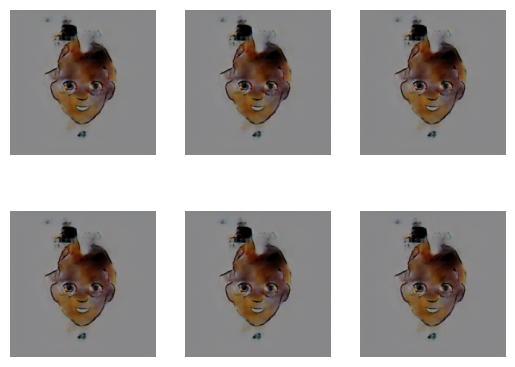

epoch:  9


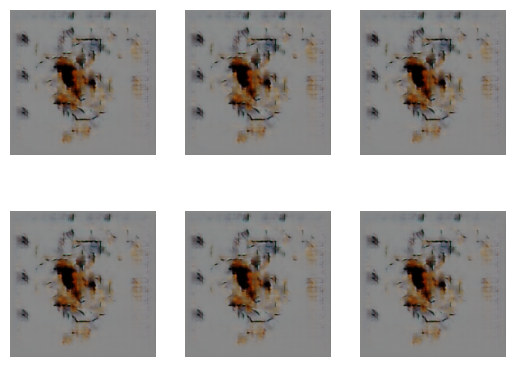

epoch:  10


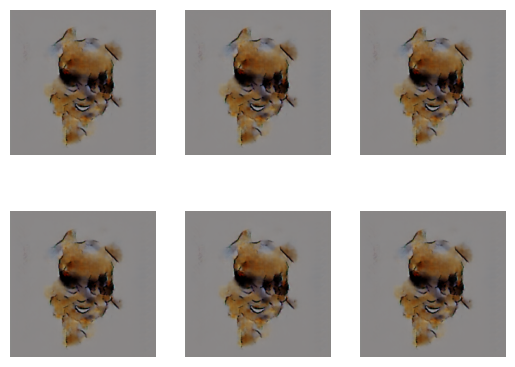

epoch:  11


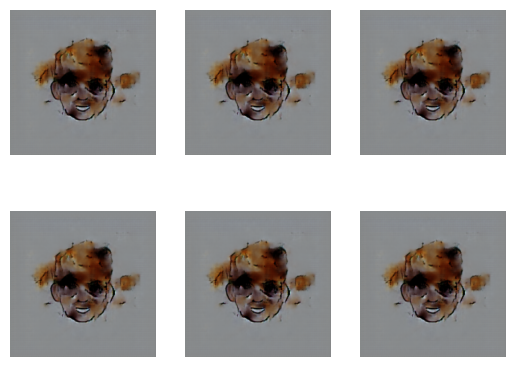

epoch:  12


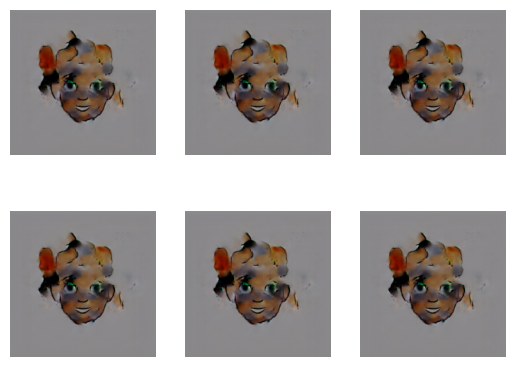

epoch:  13


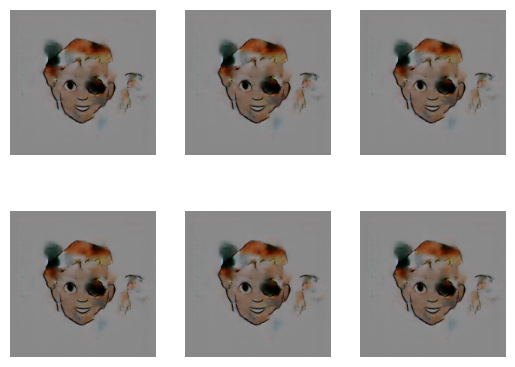

epoch:  14


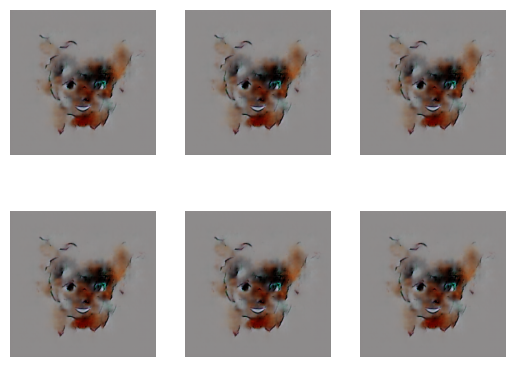

epoch:  15


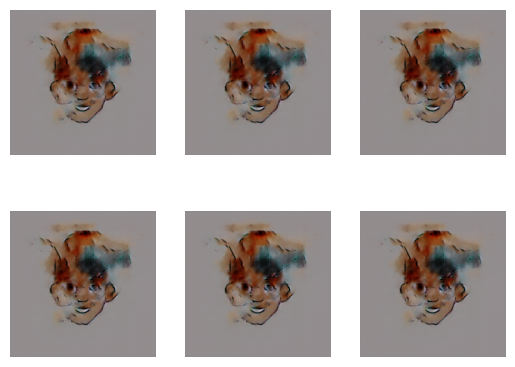

epoch:  16


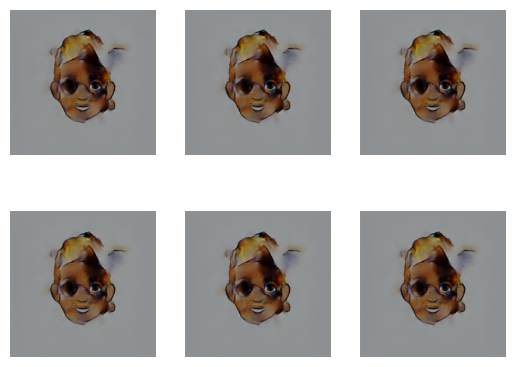

epoch:  17


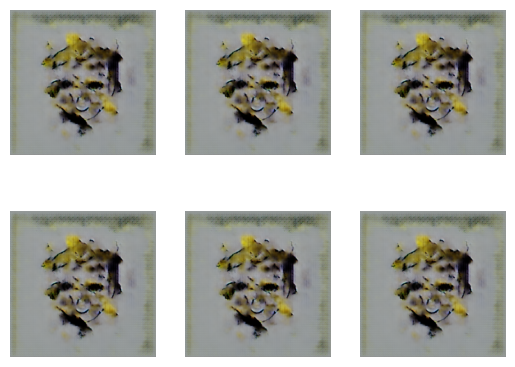

epoch:  18


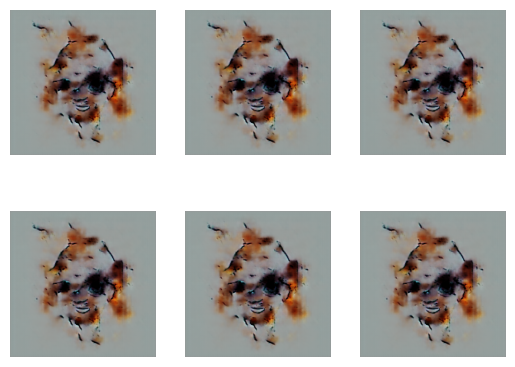

epoch:  19


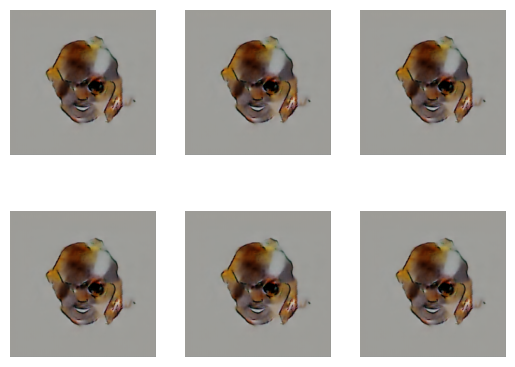

`Trainer.fit` stopped: `max_epochs=20` reached.


In [14]:
trainer = pl.Trainer(max_epochs=20, fast_dev_run=False)

dataloader = DataLoader(dataset, batch_size=16, num_workers=8)

trainer.fit(gan, dataloader)